In [1]:
%matplotlib inline


# Decoding with FREM: face vs house object recognition

This example uses fast ensembling of regularized models (FREM) to decode
a face vs house discrimination task from Haxby 2001 study. FREM uses an
implicit spatial regularization through fast clustering and aggregates a
high number of estimators trained on various splits of the training set,
thus returning a very robust decoder at a lower computational cost than
other spatially regularized methods.

To have more details, see: https://nilearn.github.io/stable/decoding/frem.html.


## Load the Haxby dataset



In [2]:
from nilearn.datasets import fetch_haxby
data_files = fetch_haxby()

# Load behavioral data
import pandas as pd
behavioral = pd.read_csv(data_files.session_target[0], sep=" ")

# Restrict to face and house conditions
conditions = behavioral['labels']
condition_mask = conditions.isin(['face', 'house'])

# Split data into train and test samples, using the chunks
condition_mask_train = (condition_mask) & (behavioral['chunks'] <= 6)
condition_mask_test = (condition_mask) & (behavioral['chunks'] > 6)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily
from nilearn.image import index_img
func_filenames = data_files.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = conditions[condition_mask_train].values
y_test = conditions[condition_mask_test].values


# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img
background_img = mean_img(func_filenames)

## Fit FREM



In [3]:
from nilearn.decoding import FREMClassifier
decoder = FREMClassifier(cv=10)
# Fit model on train data and predict on test data
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.
print("FREM classification accuracy : %g%%" % accuracy)

c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\nilearn\decoding\decoder.py:742: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  selector = check_feature_screening(
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [10420] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


FREM classification accuracy : 64.4444%


In [4]:
from nilearn.decoding import Decoder
decoder = Decoder(estimator='logistic_l2', cv=10)
# Fit model on train data and predict on test data
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.
print("Logistic-l2 classification accuracy : %g%%" % accuracy)

c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\nilearn\decoding\decoder.py:742: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  selector = check_feature_screening(
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [     0     63    255    319    383    447    511    575    703    767
    831    895    959   1023   1087   1151   1215   1279   1343   1407
   1471   1535   1599   1663   1727   1791   1855   1919   1983   2047
   2111   2175   2239   2367   2495   4094   4158   4478   4798   4862
   4926   5054   5118   5182   5630   5694   5758   5822   5886   5950
   6078   6142   6270   8188   8252   9276   9340   9404   9532   9724
  12284  12348  13627  14011  14203  16379  16443  17720  17912  18040
  20472  20536  21943  22071  24567  24631  26167  26295  28663  28727
 

Logistic-l2 classification accuracy : 68.8889%


## Visualization of FREM weights



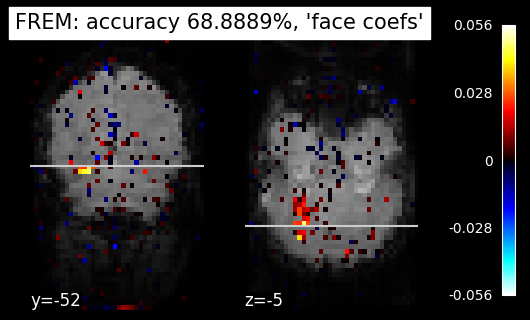

In [5]:
from nilearn import plotting
plotting.plot_stat_map(decoder.coef_img_["face"], background_img,
                       title="FREM: accuracy %g%%, 'face coefs'" % accuracy,
                       cut_coords=(-52, -5), display_mode="yz")
plotting.show()

FREM ensembling procedure yields an important improvement of decoding
accuracy on this simple example compared to fitting only one model per
fold and the clustering mechanism keeps its computational cost reasonable
even on heavier examples. Here we ensembled several instances of l2-SVC,
but FREMClassifier also works with ridge or logistic.
FREMRegressor object is also available to solve regression problems.

An important asset of this model is that the resulting brain maps are typically much easier to interpret than those returned by classic classifiers.